# Print Meta Data

In [2]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

# Load NetCDF file
def load_netcdf(file_path):
    dataset = nc.Dataset(file_path)
    return dataset

'''
Prints netcdf file metadata.

Parameters:
file_path - string path to netcdf file
'''
def print_netcdf_metadata(file_path):
    try:
        dataset = nc.Dataset(file_path)
        print("NetCDF file metadata:")
        print("Variables:")
        for var_name in dataset.variables:
            var = dataset.variables[var_name]
            print("\tVariable name:", var_name)
            print("\tDimensions:", var.dimensions)
            print("\tShape:", var.shape)
            print("\tUnits:", var.units)
            print("\tAttributes:")
            for attr_name in var.ncattrs():
                print("\t\t", attr_name, ":", getattr(var, attr_name))
            print("\n")
        print("Global attributes:")
        for attr_name in dataset.ncattrs():
            print("\t", attr_name, ":", getattr(dataset, attr_name))
        print("_________________________________________________________\n")
    except Exception as e:
        print("Error:", e)

file_paths = ['../../data/raw/weather/temp_relhum_2013.nc', '../../data/raw/weather/temp_relhum_2014.nc', \
                    '../../data/raw/weather/temp_relhum_2015.nc']

for file_path in file_paths:
    print_netcdf_metadata(file_path)

NetCDF file metadata:
Variables:
	Variable name: longitude
	Dimensions: ('longitude',)
	Shape: (5,)
	Units: degrees_east
	Attributes:
		 units : degrees_east
		 long_name : longitude


	Variable name: latitude
	Dimensions: ('latitude',)
	Shape: (5,)
	Units: degrees_north
	Attributes:
		 units : degrees_north
		 long_name : latitude


	Variable name: time
	Dimensions: ('time',)
	Shape: (8760,)
	Units: hours since 1900-01-01 00:00:00.0
	Attributes:
		 units : hours since 1900-01-01 00:00:00.0
		 long_name : time
		 calendar : gregorian


	Variable name: r
	Dimensions: ('time', 'latitude', 'longitude')
	Shape: (8760, 5, 5)
	Units: %
	Attributes:
		 scale_factor : 0.0014504882542171248
		 add_offset : 59.949481989301844
		 _FillValue : -32767
		 missing_value : -32767
		 units : %
		 long_name : Relative humidity
		 standard_name : relative_humidity


	Variable name: t
	Dimensions: ('time', 'latitude', 'longitude')
	Shape: (8760, 5, 5)
	Units: K
	Attributes:
		 scale_factor : 0.00093148908

# Combining netCDF files

In [3]:
def calculate_daily_average(data):
    # Number of hours in a day
    hours_per_day = 24

    # Reshape data to represent daily segments
    data = data.reshape(-1, hours_per_day)

    # Calculate daily averages
    day_averages = np.nanmean(data, axis=1)
    
    return day_averages
    
'''
Combines multiple years of data into the same dataframe
'''
def combine_variables(file_paths):
    temps = []
    humidities = []
    times = []
    
    for file_path in file_paths:
        # Load NetCDF file
        dataset = load_netcdf(file_path)

        # Extract temperature and humidity data
        temperature_kelvin = dataset.variables['t'][:, 0, 0]  # Assuming only one latitude and longitude point
        humidity = dataset.variables['r'][:, 0, 0]  # Assuming only one latitude and longitude point
        time = dataset.variables['time'][:]
        
        ''' Seems like scales and offsets are already applied?
        # Extract scale and offset factors from attributes for temperature and humidity
        temperature_scale = dataset.variables['t'].scale_factor
        temperature_offset = dataset.variables['t'].add_offset
        humidity_scale = dataset.variables['r'].scale_factor
        humidity_offset = dataset.variables['r'].add_offset

        # Apply scale and offset factors to temperature and humidity data and convert to celcius
        temperature = (temperature_kelvin * temperature_scale) + temperature_offset - 273.15
        humidity = (humidity * humidity_scale + humidity_offset)
        '''

        temperature = temperature_kelvin - 273.15

        # Set missing values to NaN
        temperature[temperature == -32767] = np.nan
        humidity[humidity == -32767] = np.nan

        temperature_daily = calculate_daily_average(temperature)
        humidity_daily = calculate_daily_average(humidity)
        time_daily = calculate_daily_average(time)

        temps.append(temperature_daily)
        humidities.append(humidity_daily)
        times.append(time_daily)

        dataset.close()

    all_temperature_daily = np.concatenate(temps)
    all_humidity_daily = np.concatenate(humidities)
    all_dates_daily = np.concatenate(times)

    # Convert numeric time values to datetime objects
    all_dates_daily = nc.num2date(all_dates_daily, units="hours since 1900-01-01 00:00:00.0", calendar="gregorian")
    # Convert dates to numeric format
    all_dates_daily = mdates.date2num(all_dates_daily)   

    return all_temperature_daily, all_humidity_daily, all_dates_daily


temps, humidities, dates = combine_variables(file_paths)

    

# Plotting Temperature and Relative Humidity

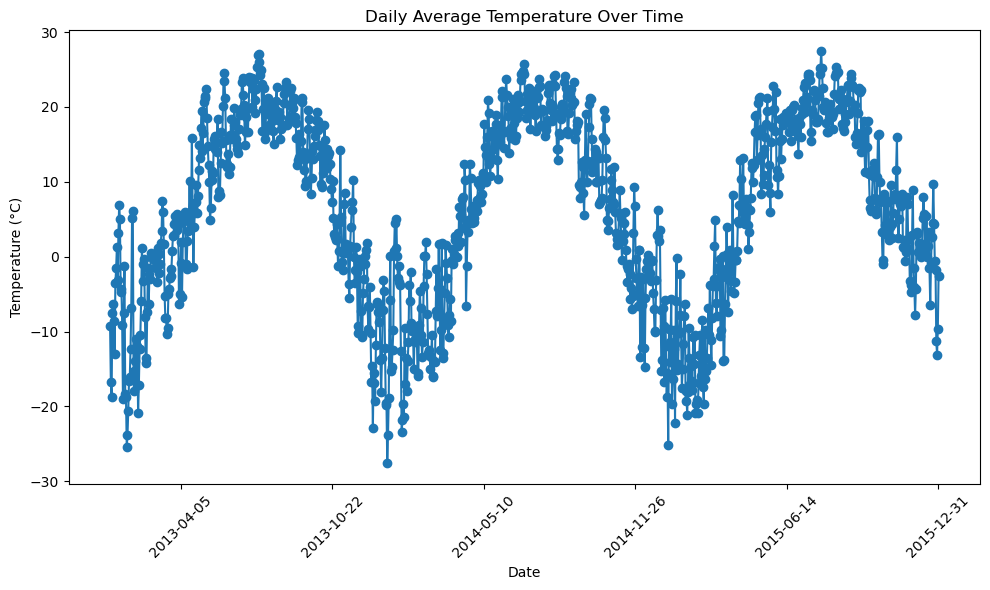

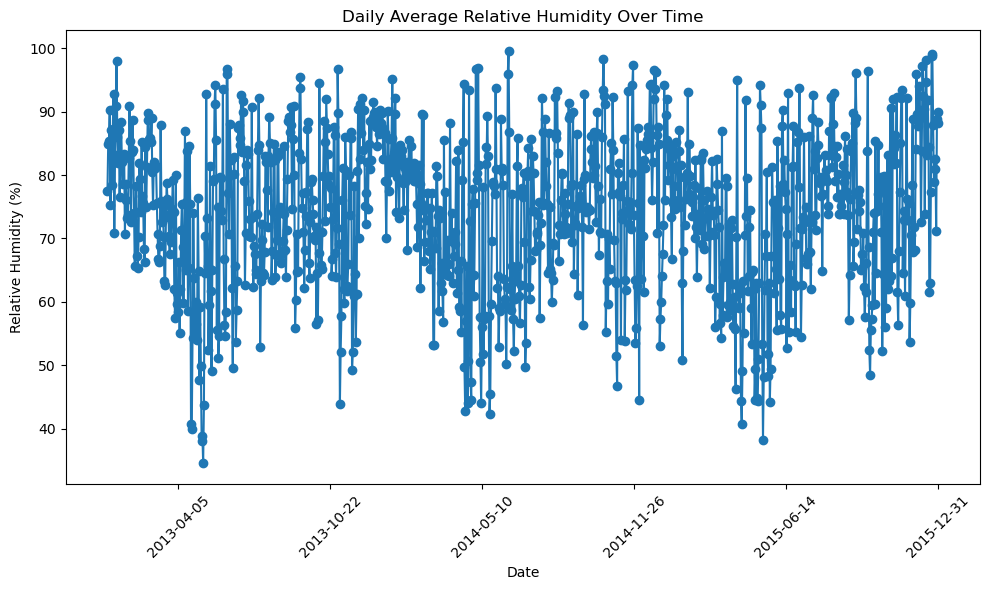

In [44]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def plot_temperature(dates, temps):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(dates, temps, marker='o', linestyle='-')
    
    # Formatting the x-axis as dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.title('Daily Average Temperature Over Time')
    
    # Display the plot
    plt.tight_layout()
    plt.savefig('../../reports/figures/Daily_Average_Temperature.png')
    plt.show()

def plot_humidity(dates, humidities):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(dates, humidities, marker='o', linestyle='-')
    
    # Formatting the x-axis as dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Relative Humidity (%)')
    plt.title('Daily Average Relative Humidity Over Time')
    
    # Display the plot
    plt.tight_layout()
    plt.savefig('../../reports/figures/Daily_Average_Relative_Humidity.png')
    plt.show()

plot_temperature(dates, temps)
plot_humidity(dates, humidities)


# Plotting Relative Humidity